riceClassification.csv  Tabular_Data_Classification.ipynb


In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#Tell pytorch to use a gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
df = pd.read_csv("riceClassification.csv")

In [3]:
df.shape

(18185, 12)

In [4]:
df

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
18180,18181,5853,148.624571,51.029281,0.939210,6008,86.326537,0.498594,332.960,0.663444,2.912535,0
18181,18182,7585,169.593996,58.141659,0.939398,7806,98.272692,0.647461,385.506,0.641362,2.916910,0
18182,18183,6365,154.777085,52.908085,0.939760,6531,90.023162,0.561287,342.253,0.682832,2.925396,0
18183,18184,5960,151.397924,51.474600,0.940427,6189,87.112041,0.492399,343.371,0.635227,2.941216,0


In [5]:
df["Class"].value_counts()

Class
1    9985
0    8200
Name: count, dtype: int64

In [6]:
df.loc[df.isna().any(axis=1)]

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class


,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class


In [7]:

# inplace=True modifies the original df, meaning it does
#not create a copy as it normally does (inplace is set to False by default)

# 1. Drop any null values (even if there is only one, the entire row will be removed)
df.dropna(inplace=True)

# 2. Drop "id" column, since it is not required
df.drop(["id"], axis=1, inplace=True)
df.shape

(18185, 11)

## Max-Abs Normalization (Maximum Absolute Scaling)

> Max-Abs Normalization scales each feature individually by dividing it by its maximum absolute value, such that the resulting values lie in the range **[-1, 1]**.

 **Mathematical Formula:**
$$
X_i^{\text{normalized}} = \frac{x_i}{\max(|X|)}
$$

Where:

- $max(∣X∣)$ is the **maximum absolute value** in the column $X$
- This ensures that the largest value (in magnitude) becomes **1 or -1**

In [8]:
  #Normalize values

df_o =df.copy()

for column in df.columns:
    df[column] = df[column]/df[column].abs().max()


df

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0
...,...,...,...,...,...,...,...,...,...,...,...
18180,0.573262,0.811219,0.618156,0.971489,0.545785,0.757140,0.562384,0.654774,0.733291,0.744543,0.0
18181,0.742899,0.925674,0.704314,0.971683,0.709121,0.861916,0.730296,0.758107,0.708884,0.745661,0.0
18182,0.623408,0.844800,0.640916,0.972058,0.593296,0.789562,0.633098,0.673049,0.754720,0.747830,0.0
18183,0.583741,0.826356,0.623551,0.972748,0.562227,0.764030,0.555396,0.675248,0.702103,0.751874,0.0


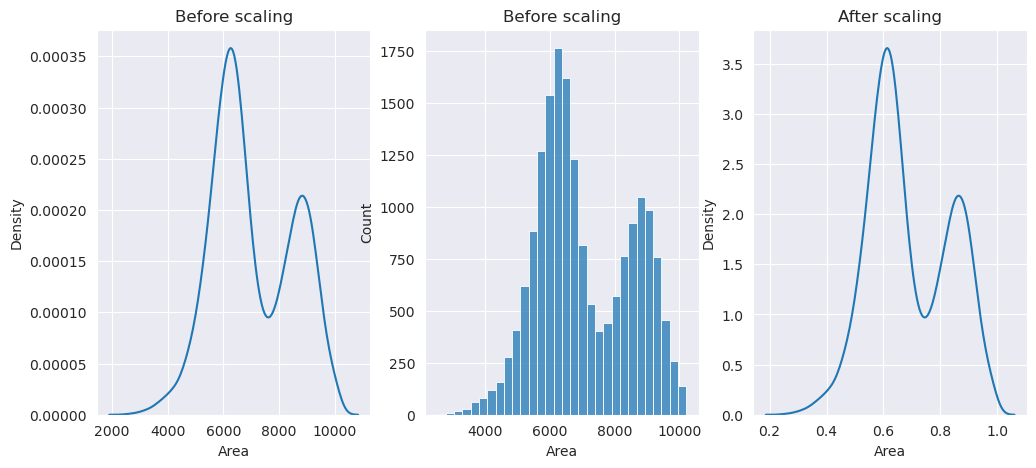

In [9]:
import seaborn as sns
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(12, 5))
#Before scaling
ax1.set_title("Before scaling")
sns.kdeplot(df_o["Area"], ax=ax1)

ax2.set_title("Before scaling")
sns.histplot(df_o["Area"], ax=ax2, bins=30)  # Use histogram for actual counts


#After scaling
ax3.set_title("After scaling")
sns.kdeplot(df["Area"], ax=ax3)


plt.show()

## Spliting dataset

In [10]:
#Splitting data set

# Take all rows ":", and take all columns except the last one ":-1"

X = np.array(df.iloc[:,:-1])


# Take all rows ":", and take only the last column
Y = np.array(df.iloc[:,-1])

In [11]:
df.iloc[:,:-1]

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007
...,...,...,...,...,...,...,...,...,...,...
18180,0.573262,0.811219,0.618156,0.971489,0.545785,0.757140,0.562384,0.654774,0.733291,0.744543
18181,0.742899,0.925674,0.704314,0.971683,0.709121,0.861916,0.730296,0.758107,0.708884,0.745661
18182,0.623408,0.844800,0.640916,0.972058,0.593296,0.789562,0.633098,0.673049,0.754720,0.747830
18183,0.583741,0.826356,0.623551,0.972748,0.562227,0.764030,0.555396,0.675248,0.702103,0.751874


In [12]:
df.iloc[:,-1]

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
18180    0.0
18181    0.0
18182    0.0
18183    0.0
18184    0.0
Name: Class, Length: 18185, dtype: float64

### 70% Training:
- **X_train**: Features for training.
- **y_train**: Labels for training.

### 15% Validation (half of 30% test data):
- **X_val**: Features for validation.
- **y_val**: Labels for validation.

### 15% Testing (half of 30% test data):
- **X_test**: Features for testing.
- **y_test**: Labels for testing.

In [13]:
# test_size=0.3 means that the 70% of the data will become the training set
# and the remaining 30% corresponds to the test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)



# Now we will split in half the test set, and we'll have 50% of the data for the validation set and 50% for the test set

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [15]:
train = 18185*0.7
print(train)
test = 18185*0.3
print(test)
val = test*0.5
print(val)


12729.5
5455.5
2727.75


In [16]:
12729+2728+2728

18185

In [17]:
# Dataset object
class dataset(Dataset):
  def __init__(self,X,Y):
    self.X = torch.tensor(X,dtype=torch.float32).to(device)
    self.Y = torch.tensor(Y,dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self,index):
    return self.X[index], self.Y[index]




In [18]:
traning_data = dataset(X_train, y_train)
validation_dat = dataset(X_val, y_val)
test_data = dataset(X_test, y_test)

traning_data

In [19]:
# DataLader is an object you use to specify the batch size (32 rows) during each epoch
# it receives a Dataset object as parameter
train_dataloader = DataLoader(traning_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dat, batch_size=32, shuffle=True)
testing_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [20]:
x_item, y_item = test_data[0]  # Fetch the data at index 0

# Print the result
print(f"X: {x_item}, Y: {y_item}")

X: tensor([0.8910, 0.8513, 0.9131, 0.9055, 0.8433, 0.9439, 0.9004, 0.7497, 0.8693,
        0.5289], device='cuda:0'), Y: 0.0


In [21]:
# Data loader will give you 32 rows every time you iterate over it
# You can see that by counting the 32 data tensors and class tensors it retrieves in the first iteration

for x,y in train_dataloader:
  print(x)
  print("=======")
  print(y)
  break

tensor([[0.5107, 0.8215, 0.5433, 0.9874, 0.4906, 0.7146, 0.4880, 0.6469, 0.6692,
         0.8578],
        [0.6316, 0.8892, 0.6242, 0.9813, 0.6129, 0.7948, 0.6257, 0.7320, 0.6464,
         0.8082],
        [0.5625, 0.7984, 0.6123, 0.9707, 0.5349, 0.7500, 0.6809, 0.6458, 0.7396,
         0.7398],
        [0.8989, 0.8682, 0.9060, 0.9129, 0.8637, 0.9481, 0.7990, 0.7632, 0.8463,
         0.5436],
        [0.6183, 0.7067, 0.7615, 0.9043, 0.5892, 0.7863, 0.6975, 0.6184, 0.8866,
         0.5265],
        [0.8844, 0.8544, 0.9058, 0.9087, 0.8462, 0.9404, 0.7529, 0.7492, 0.8642,
         0.5352],
        [0.9107, 0.8686, 0.9109, 0.9116, 0.8652, 0.9543, 0.6677, 0.7541, 0.8782,
         0.5410],
        [0.6239, 0.8620, 0.6345, 0.9758, 0.5999, 0.7899, 0.8857, 0.6955, 0.7074,
         0.7708],
        [0.6117, 0.8749, 0.6162, 0.9809, 0.5855, 0.7821, 0.6140, 0.6927, 0.6991,
         0.8055],
        [0.8991, 0.8964, 0.8747, 0.9290, 0.8616, 0.9482, 0.7392, 0.7767, 0.8174,
         0.5814],
        [0

In [22]:
HIDDEN_NEURONS=10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()

    self.input_layer= nn.Linear(X.shape[1],HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS,1)
    self.sigmoid = nn.Sigmoid()


  # HOw data flows within the model
  def forward(self,x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

model = MyModel().to(device)


In [23]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [24]:
# Binary Cross Entropy Loss (used for binary classification problems)
criterion = nn.BCELoss()

# Adam optimizer with a learning rate of 1e-3
optimizer = Adam(model.parameters(), lr=1e-3)

In [25]:


# Binary Cross Entropy Loss (used for binary classification problems)
criterion = nn.BCELoss()

# Adam optimizer with a learning rate of 1e-3
optimizer = Adam(model.parameters(), lr=1e-3)

# Lists to store loss and accuracy for training and validation over epochs
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

# Number of training epochs
EPOCHS = 10

# Training loop
for epoch in range(EPOCHS):
    total_acc_train = 0  # Variable to accumulate training accuracy
    total_loss_train = 0  # Variable to accumulate training loss
    total_acc_val = 0  # Variable to accumulate validation accuracy
    total_loss_val = 0  # Variable to accumulate validation loss

    # Loop through each batch in the training dataset
    for data in train_dataloader:
        inputs, labels = data  # Get input features and corresponding labels

        prediction = model(inputs).squeeze(1)  # Forward pass through the model

        batch_loss = criterion(prediction, labels)  # Compute loss

        total_loss_train += batch_loss.item()  # Accumulate training loss

        # Compute accuracy: round predictions to 0 or 1 and compare with labels
        acc = ((prediction).round() == labels).sum().item()
        total_acc_train += acc  # Accumulate correct predictions

        batch_loss.backward()  # Compute gradients via backpropagation
        optimizer.step()  # Update model weights
        optimizer.zero_grad()  # Reset gradients for the next batch

    # Disable gradient computation during validation to save memory
    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data  # Get input features and labels

            prediction = model(inputs).squeeze(1)  # Forward pass

            batch_loss = criterion(prediction, labels)  # Compute loss
            total_loss_val += batch_loss.item()  # Accumulate validation loss

            # Compute accuracy for validation set
            acc = ((prediction).round() == labels).sum().item()
            total_acc_val += acc  # Accumulate correct predictions

    total_loss_train_plot.append(round(total_loss_train / 1000,4))
    total_loss_val_plot.append(round(total_loss_val / 1000,4))

    total_acc_train_plot.append(round(total_acc_train / traning_data.__len__()*100,4))
    total_acc_val_plot.append(round(total_acc_val / validation_dat.__len__()*100,4))

    print(f"""Epoch {epoch + 1} Train Loss:{round(total_loss_train / 1000,4)} Train Accuracy: {round(total_acc_train / traning_data.__len__()*100,4)}
              Validation Loss: {round(total_loss_val / 1000,4)} Validation Accuracy: {round(total_acc_val / validation_dat.__len__()*100,4)}""")
    
torch.save(model.state_dict(), 'rice_classification_model.pt')




Epoch 1 Train Loss:0.2192 Train Accuracy: 90.0228
              Validation Loss: 0.0336 Validation Accuracy: 97.2141
Epoch 2 Train Loss:0.1054 Train Accuracy: 97.6667
              Validation Loss: 0.0148 Validation Accuracy: 98.3138
Epoch 3 Train Loss:0.0527 Train Accuracy: 98.2402
              Validation Loss: 0.0087 Validation Accuracy: 98.3504
Epoch 4 Train Loss:0.0351 Train Accuracy: 98.3502
              Validation Loss: 0.0065 Validation Accuracy: 98.5704
Epoch 5 Train Loss:0.0275 Train Accuracy: 98.4602
              Validation Loss: 0.0054 Validation Accuracy: 98.4971
Epoch 6 Train Loss:0.0236 Train Accuracy: 98.5388
              Validation Loss: 0.0047 Validation Accuracy: 98.5337
Epoch 7 Train Loss:0.0213 Train Accuracy: 98.5545
              Validation Loss: 0.0043 Validation Accuracy: 98.717
Epoch 8 Train Loss:0.0199 Train Accuracy: 98.5859
              Validation Loss: 0.004 Validation Accuracy: 98.6804
Epoch 9 Train Loss:0.0191 Train Accuracy: 98.5466
              Va

In [26]:
with torch.no_grad():
  total_loss_test=0
  total_acc_test=0

  for data in testing_dataloader:
    inputs, labels = data
    prediction = model(inputs).squeeze(1)
    batch_loss_test = criterion(prediction, labels)
    total_loss_test += batch_loss.item()

    acc_test = ((prediction).round() == labels).sum().item()
    total_acc_test += acc_test

print(f"""Test Loss: {round(total_loss_test / 1000,4)} Test Accuracy: {round(total_acc_test / test_data.__len__()*100,4)}""")


Test Loss: 0.0032 Test Accuracy: 98.7903


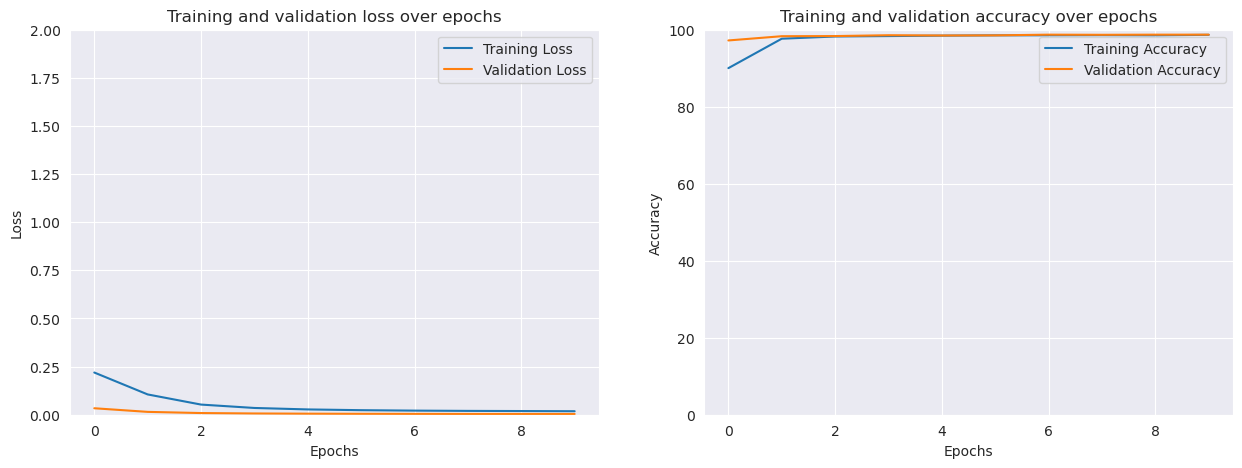

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Plot for Loss
axs[0].plot(total_loss_train_plot, label="Training Loss")
axs[0].plot(total_loss_val_plot, label="Validation Loss")
axs[0].set_title("Training and validation loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0, 2])
axs[0].legend()  # Corrected: Use legend for this subplot

# Plot for Accuracy
axs[1].plot(total_acc_train_plot, label="Training Accuracy")
axs[1].plot(total_acc_val_plot, label="Validation Accuracy")
axs[1].set_title("Training and validation accuracy over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0, 100])
axs[1].legend()  # Corrected: Use legend for this subplot

plt.show()  # Ensure the plots are displayed


## New data point

In [28]:
# Creating variables for max values of each column
area_max = df_o["Area"].abs().max()
major_axis_max = df_o["MajorAxisLength"].abs().max()
minor_axis_max = df_o["MinorAxisLength"].abs().max()
eccentricity_max = df_o["Eccentricity"].abs().max()
convex_area_max = df_o["ConvexArea"].abs().max()
equiv_diameter_max = df_o["EquivDiameter"].abs().max()
extent_max = df_o["Extent"].abs().max()
perimeter_max = df_o["Perimeter"].abs().max()
roundness_max = df_o["Roundness"].abs().max()
aspect_ratio_max = df_o["AspectRation"].abs().max()

# Creating normalized variables for new data
area_norm = 2353 / area_max
major_axis_norm = 81 / major_axis_max
minor_axis_norm = 50 / minor_axis_max
eccentricity_norm = 0.7 / eccentricity_max
convex_area_norm = 2500 / convex_area_max
equiv_diameter_norm = 50 / equiv_diameter_max
extent_norm = 0.7 / extent_max
perimeter_norm = 200 / perimeter_max
roundness_norm = 0.85 / roundness_max
aspect_ratio_norm = 2.4 / aspect_ratio_max



# Creating a tensor from the normalized values
new_data = torch.tensor([
    area_norm,
    major_axis_norm,
    minor_axis_norm,
    eccentricity_norm,
    convex_area_norm,
    equiv_diameter_norm,
    extent_norm,
    perimeter_norm,
    roundness_norm,
    aspect_ratio_norm
], dtype=torch.float32).to(device)  # Ensure correct data type



# Make a prediction using the trained model
prediction = model(new_data)

# Print the prediction result
print("Model Prediction:", round(prediction.item()))


Model Prediction: 1
